In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import tensorflow.keras as keras
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams['font.size']        = 18 # standard er 45
mpl.rcParams['lines.markersize'] = 13
plt.rcParams['figure.constrained_layout.use'] = True

## Training data model combination and Umap

In [2]:
# Loading training data

data = np.load('data_meta.npz',allow_pickle = True)

print(data)

meta = np.array(data['meta'])
# ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

label = np.array(data['label'])
data = np.array(data['data'])
#mid = np.array(data['metaid'])

In [3]:
print(meta.shape)
print(data.shape)
print(label.shape)

(42000, 39)
(42000, 64, 64)
(42000,)


In [4]:
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)
data =  standardizeimg(img=data, mu=np.mean(data), sigma=np.std(data))
meta =  standardizeimg(img=meta, mu=np.mean(meta), sigma=np.std(meta))

In [5]:
data = data.reshape(data.shape[0], data.shape[1],data.shape[2], 1)

In [6]:
data1 = [data,meta]
print(data1[0].shape)
print(data1[1].shape)

(42000, 64, 64, 1)
(42000, 39)


In [7]:
NoP = 7000

np.random.seed(42)

sample = np.random.randint(0,len(data1[1][:,0]),NoP)

data_small = [data1[0][sample],data1[1][sample]]
label_small = label[sample]
print(data_small[0].shape)
print(data_small[1].shape)

(7000, 64, 64, 1)
(7000, 39)


In [8]:
model_3 = keras.models.load_model("model_3type_Martin_64_new")
model_ash = keras.models.load_model("model_ash") # camp og grim , [0,3]
model_pollen = keras.models.load_model("model_pollen")

In [9]:

sub_label = np.array([0,1,2,0,1,1])[label_small].flatten()

print(sub_label.shape)


(7000,)


In [10]:
prediction_p = model_3.predict(data_small)

In [11]:
extractor = tf.keras.Model(inputs=model_3.inputs,
                        outputs=model_3.layers[-2].output)

features = extractor(data_small)


In [12]:
import umap
reducer = umap.UMAP()
reducer.fit(features)
umap_transformed = reducer.transform(features)

f_0 = umap_transformed[label_small == 0] 
f_1 = umap_transformed[label_small == 1] 
f_2 = umap_transformed[label_small == 2] 
f_3 = umap_transformed[label_small == 3] 
f_4 = umap_transformed[label_small == 4] 
f_5 = umap_transformed[label_small == 5] 

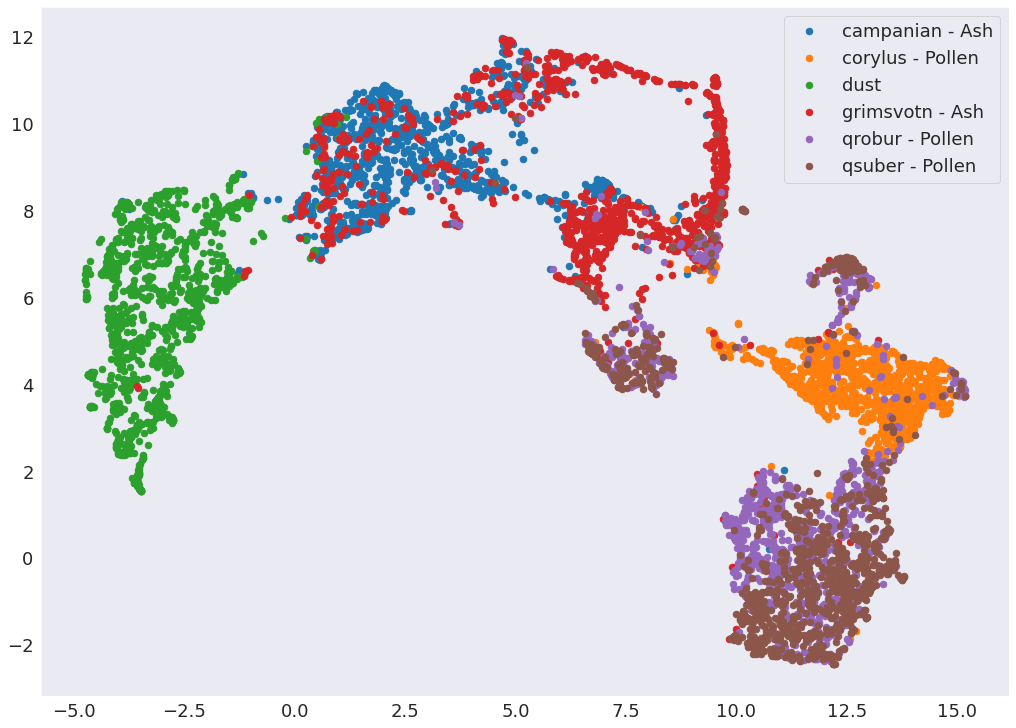

In [13]:
plt.figure(figsize=(14,10))
plt.plot(f_0[:,0],f_0[:,1],'.', label = "campanian - Ash")
plt.plot(f_1[:,0],f_1[:,1],'.', label = "corylus - Pollen")
plt.plot(f_2[:,0],f_2[:,1],'.', label = "dust")
plt.plot(f_3[:,0],f_3[:,1],'.', label = "grimsvotn - Ash")
plt.plot(f_4[:,0],f_4[:,1],'.', label = "qrobur - Pollen")
plt.plot(f_5[:,0],f_5[:,1],'.', label = "qsuber - Pollen")
plt.grid(False)
plt.savefig('umap_3categories.png')
plt.legend()

plt.show()

In [14]:
predictions = np.argmax(prediction_p, axis=1)

predicted = np.zeros(len(predictions))


pollen = [data_small[0][predictions == 1],data_small[1][predictions == 1]]
label_pollen = label_small[predictions == 1]

ash = [data_small[0][predictions == 0],data_small[1][predictions == 0]]
label_ash = label_small[predictions == 0]

dust = [data_small[0][predictions == 2],data_small[1][predictions == 2]]
predicted[predictions == 2] = 2


index_pollen = np.asarray(np.where(predictions == 1))
index_ash = np.array(np.where(predictions == 0))
index_dust = np.array(np.where(predictions == 2))

index_pollen = index_pollen[0]
index_ash = index_ash[0]
index_dust = index_dust[0]


### Dust


dust_img = data_small[0][index_dust]
dust_meta = data_small[1][index_dust]

dust_data = [data_small[0][index_dust],data_small[1][index_dust]]
dust_result = np.stack((predictions[predictions==2], index_dust),1)



In [15]:
# Pollen prediction

pollen_img = data_small[0][index_pollen]
pollen_meta = data_small[1][index_pollen]

pollen_data = [data_small[0][index_pollen],data_small[1][index_pollen]]

prediction_pollen_p = model_pollen.predict(pollen_data)

predictions_pollen = np.argmax(prediction_pollen_p, axis=1)

predicted_pollen = np.zeros(len(predictions_pollen))

predictions_pollen = np.array([1,4,5])[predictions_pollen]

#predictions_pollen[predictions_pollen == 0] = 1
#predictions_pollen[predictions_pollen == 1] = 4
#predictions_pollen[predictions_pollen == 2] = 5

pollen_result = np.stack((predictions_pollen, index_pollen),1)
print(index_pollen)

[   2    3    6 ... 6995 6997 6999]


In [16]:
extractor_p = tf.keras.Model(inputs=model_pollen.inputs,
                        outputs=model_pollen.layers[-2].output)

features_pollen = extractor_p(pollen_data)

In [17]:
reducer_p = umap.UMAP()
reducer_p.fit(features_pollen)
umap_transformed_p = reducer_p.transform(features_pollen)


f_0 = umap_transformed_p[label_small[index_pollen] == 0] 
f_1 = umap_transformed_p[label_small[index_pollen] == 1] 
f_2 = umap_transformed_p[label_small[index_pollen] == 2] 
f_3 = umap_transformed_p[label_small[index_pollen] == 3]
f_4 = umap_transformed_p[label_small[index_pollen] == 4]
f_5 = umap_transformed_p[label_small[index_pollen] == 5]

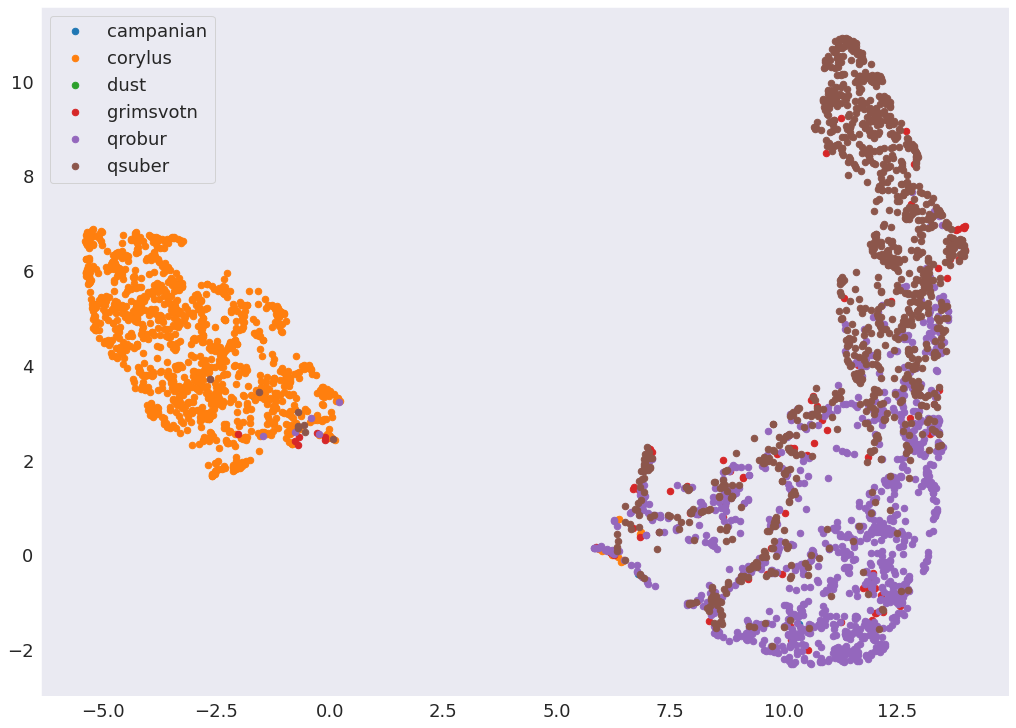

In [18]:
# ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

plt.figure(figsize=(14,10))
plt.plot(f_0[:,0],f_0[:,1],'.', label = "campanian")
plt.plot(f_1[:,0],f_1[:,1],'.', label = "corylus")
plt.plot(f_2[:,0],f_2[:,1],'.', label = "dust")
plt.plot(f_3[:,0],f_3[:,1],'.', label = "grimsvotn")
plt.plot(f_4[:,0],f_4[:,1],'.', label = "qrobur")
plt.plot(f_5[:,0],f_5[:,1],'.', label = "qsuber")
plt.grid(False)
plt.savefig('umap_train_pollen.png')
plt.legend()

plt.show()

In [19]:
# Ash prediction

ash_img = data_small[0][index_ash]
ash_meta = data_small[1][index_ash]

ash_data = [data_small[0][index_ash],data_small[1][index_ash]]

prediction_ash_p = model_ash.predict(ash_data)

predictions_ash = np.argmax(prediction_ash_p, axis=1)

predicted_ash = np.zeros(len(predictions_ash))

predictions_ash[predictions_ash==0] = 0 
predictions_ash[predictions_ash==1] = 3

ash_result = np.stack((predictions_ash, index_ash),1)



In [20]:
extractor_a = tf.keras.Model(inputs=model_ash.inputs,
                        outputs=model_ash.layers[-2].output)

features_ash = extractor_a(ash_data)

In [21]:
reducer_a = umap.UMAP()
reducer_a.fit(features_ash)
umap_transformed_a = reducer_a.transform(features_ash)


f_0_a = umap_transformed_a[label_small[index_ash] == 0] 
f_1_a = umap_transformed_a[label_small[index_ash] == 1] 
f_2_a = umap_transformed_a[label_small[index_ash] == 2] 
f_3_a = umap_transformed_a[label_small[index_ash] == 3]
f_4_a = umap_transformed_a[label_small[index_ash] == 4]
f_5_a = umap_transformed_a[label_small[index_ash] == 5]

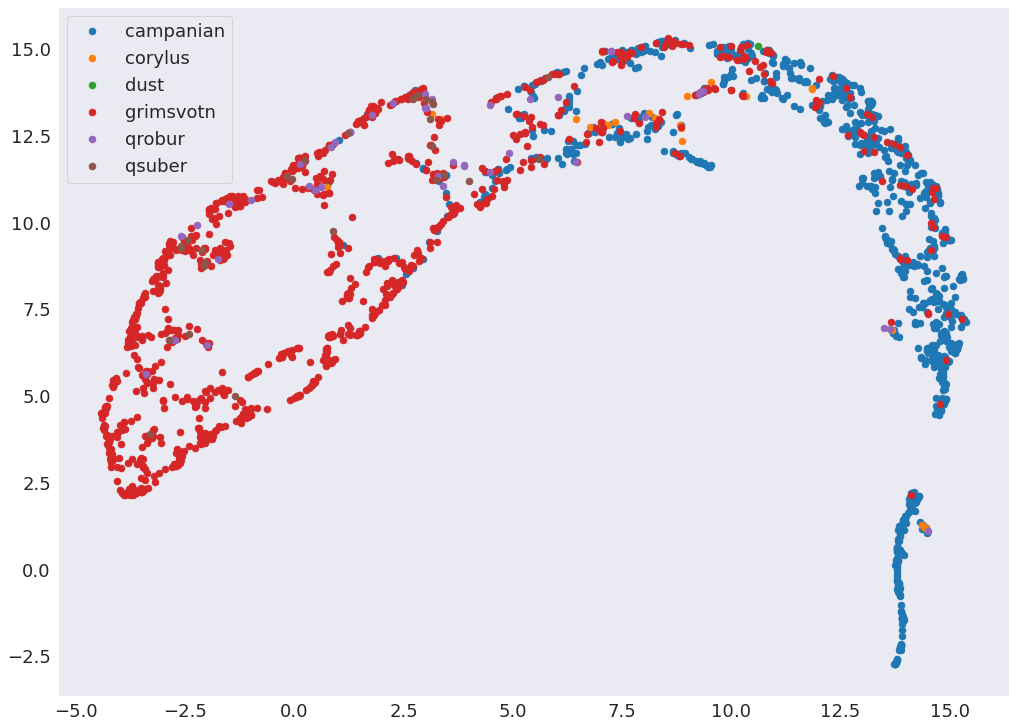

In [22]:
# ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

plt.figure(figsize=(14,10))
plt.plot(f_0_a[:,0],f_0_a[:,1],'.', label = "campanian")
plt.plot(f_1_a[:,0],f_1_a[:,1],'.', label = "corylus")
plt.plot(f_2_a[:,0],f_2_a[:,1],'.', label = "dust")
plt.plot(f_3_a[:,0],f_3_a[:,1],'.', label = "grimsvotn")
plt.plot(f_4_a[:,0],f_4_a[:,1],'.', label = "qrobur")
plt.plot(f_5_a[:,0],f_5_a[:,1],'.', label = "qsuber")
plt.grid(False)
plt.savefig('umap_train_ash.png')
plt.legend()

plt.show()

In [23]:
tot_predictions = np.vstack((dust_result, pollen_result, ash_result))

print(tot_predictions)

tot_predictions = pd.DataFrame(tot_predictions)

tot_predictions = tot_predictions.sort_values(1)
tot_predictions = tot_predictions[0].to_numpy()
print(tot_predictions)

[[   2    0]
 [   2    5]
 [   2    8]
 ...
 [   0 6993]
 [   3 6994]
 [   0 6996]]
[2 0 5 ... 5 2 1]


In [24]:
print(len(tot_predictions))
print(len(label_small))

7000
7000


In [25]:
conf_matrix = tf.math.confusion_matrix(labels=label_small, predictions=tot_predictions, num_classes=6)
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate



plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)

path = ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

plt.xticks(range(len(path)),path, rotation=20)
plt.yticks(range(len(path)),path, rotation=20)
plt.setp( ax.xaxis.get_majorticklabels()) 

import matplotlib.transforms

# Create offset transform by 5 points in x direction
dx = 50/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.setp( ax.yaxis.get_majorticklabels()) 

# Create offset transform by 5 points in x direction
dx = 0/72.; dy = 50/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
plt.tight_layout()
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))
fig.savefig('subtypes_conf_matrix', dpi=75)

#print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
#print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

## Model prediction on test and umap

In [26]:
data_t = np.load('test_ice_core.npz',allow_pickle = True)

print(data_t)

print(data_t['test_meta'])

NoP = 4000#len(data_t['test_meta'])

meta_t = np.array(*data_t['test_meta'])[:NoP]

data_t = np.array(data_t['test_img'])[:NoP]

print(meta_t.shape)

# ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

[[[0.06       0.         1.         ... 0.01091299 0.01091299 0.28      ]
  [4.36       4.36       0.94       ... 6.849509   8.151848   2.34      ]
  [0.08       0.08       0.         ... 0.01567867 0.03356812 0.28      ]
  ...
  [0.21       0.21       0.66       ... 0.07150034 0.09209839 0.43      ]
  [0.57       0.57       0.9        ... 0.3220334  0.3754204  0.83      ]
  [3.87       3.87       0.64       ... 5.724967   8.075991   1.51      ]]]
(4000, 39)


In [27]:
data_t =  standardizeimg(img=data_t, mu=np.mean(data_t), sigma=np.std(data_t))
meta_t =  standardizeimg(img=meta_t, mu=np.mean(meta_t), sigma=np.std(meta_t))

In [28]:
#data_t = data_t.reshape(data_t.shape[0], data_t.shape[1],data_t.shape[2], 1)


data1_t = [data_t,meta_t]
print(data1_t[0].shape)
print(data1_t[1].shape)

data_test = [data1_t[0],data1_t[1]]


(4000, 64, 64)
(4000, 39)


In [29]:
prediction_test_p = model_3.predict(data_test)

In [30]:
extractor_test_3 = tf.keras.Model(inputs=model_3.inputs,
                        outputs=model_3.layers[-2].output)

features_test_3 = extractor_test_3(data_test)

In [31]:

umap_transformed_t3 = reducer.transform(features_test_3)

f_0_t3 = umap_transformed_t3

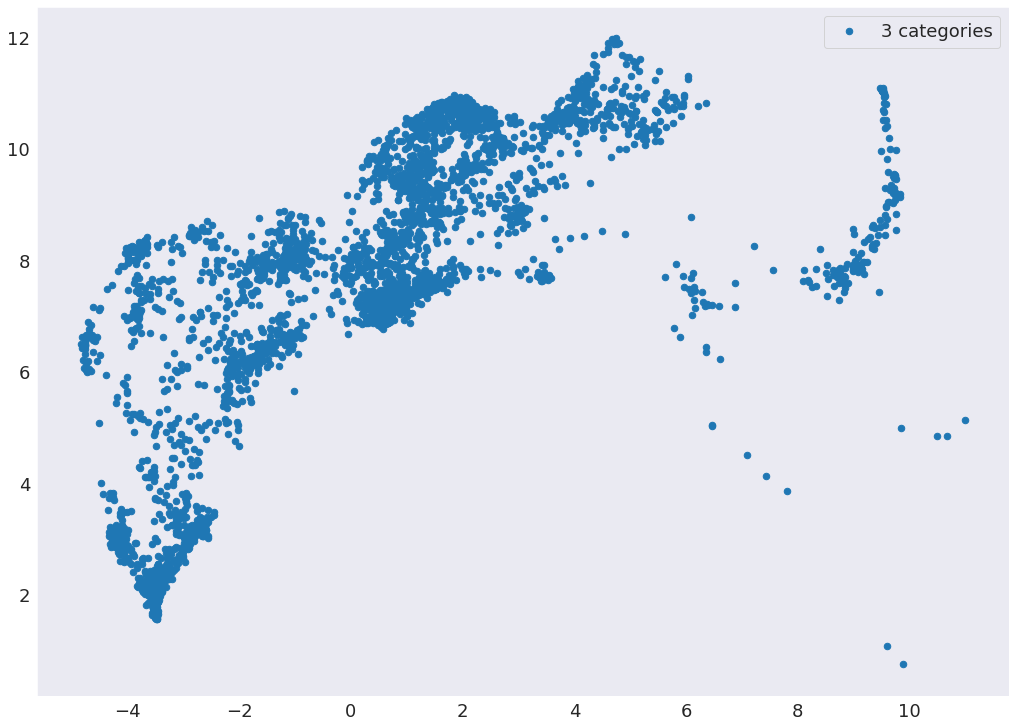

In [32]:
plt.figure(figsize=(14,10))
plt.plot(f_0_t3[:,0],f_0_t3[:,1],'.', label = "3 categories")
plt.grid(False)
plt.savefig('test_umap_samespace.png')
plt.legend()

plt.show()

In [33]:
predictions_t = np.argmax(prediction_test_p, axis=1)

print(predictions_t)


index_pollen_t = np.asarray(np.where(predictions_t == 1))
index_ash_t = np.array(np.where(predictions_t == 0))
index_dust_t = np.array(np.where(predictions_t == 2))

index_pollen_t = index_pollen_t[0]
index_ash_t = index_ash_t[0]
index_dust_t = index_dust_t[0]


### Dust


#dust_img = data_test[0][index_dust]
#dust_meta = data_test[1][index_dust]

dust_data = [data_test[0][index_dust_t],data_test[1][index_dust_t]]
dust_result = np.stack((predictions_t[predictions_t==2], index_dust_t),1)


[2 0 2 ... 0 2 0]


In [34]:
# Pollen prediction

pollen_img_t = data_test[0][index_pollen_t]
pollen_meta_t = data_test[1][index_pollen_t]

pollen_data_t = [data_test[0][index_pollen_t],data_test[1][index_pollen_t]]

prediction_pollen_p_tp = model_pollen.predict(pollen_data_t)

predictions_pollen_tp = np.argmax(prediction_pollen_p_tp, axis=1)

predicted_pollen_tp = np.zeros(len(predictions_pollen_tp))

predictions_pollen_tp = np.array([1,4,5])[predictions_pollen_tp]

#predictions_pollen[predictions_pollen == 0] = 1
#predictions_pollen[predictions_pollen == 1] = 4
#predictions_pollen[predictions_pollen == 2] = 5

pollen_result_t = np.stack((predictions_pollen_tp, index_pollen_t),1)
print(index_pollen_t)

[ 641 1890 1956 2255 2911 3021 3295 3545 3692 3979]


In [35]:


features_pollen_t = extractor_p(pollen_data_t)

In [36]:
umap_transformed_p_t = reducer_a.transform(features_pollen_t)


f_0_pt = umap_transformed_p_t

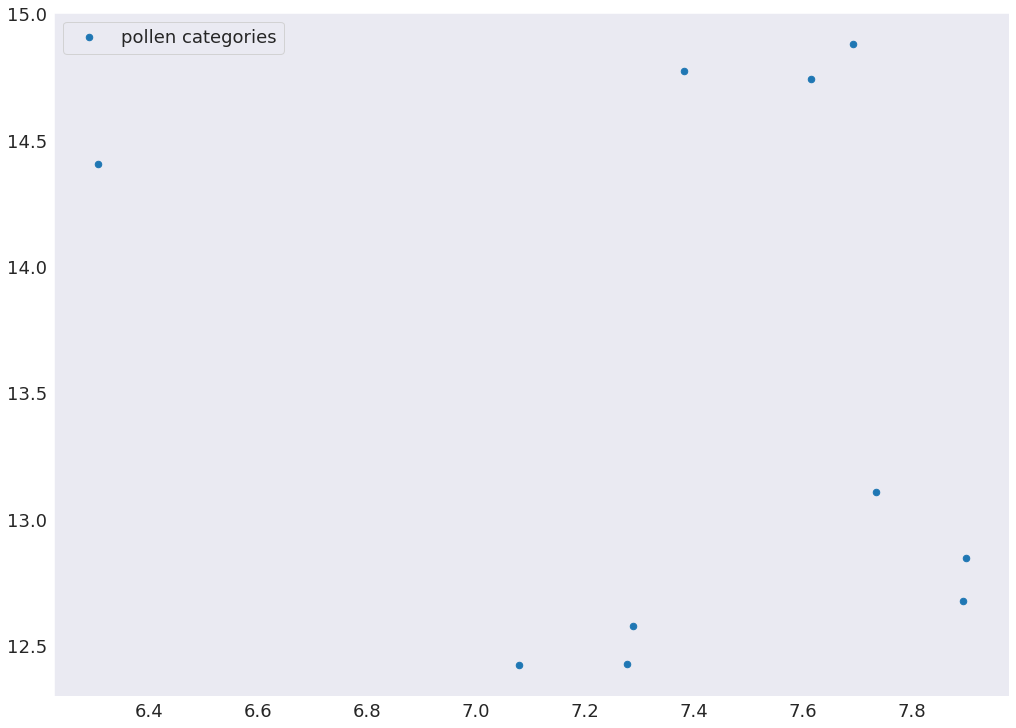

In [37]:
plt.figure(figsize=(14,10))
plt.plot(f_0_pt[:,0],f_0_pt[:,1],'.', label = "pollen categories")
plt.grid(False)
plt.savefig('test_umap_samespace_pollen.png')
plt.legend()

plt.show()

In [38]:
# Ash prediction

ash_img_t = data_test[0][index_ash_t]
ash_meta_t = data_test[1][index_ash_t]

ash_data_t = [data_test[0][index_ash_t],data_test[1][index_ash_t]]

prediction_ash_p_t = model_ash.predict(ash_data_t)

predictions_ash_t = np.argmax(prediction_ash_p_t, axis=1)

predicted_ash_t = np.zeros(len(predictions_ash_t))

predictions_ash_t[predictions_ash_t==0] = 0 
predictions_ash_t[predictions_ash_t==1] = 3

ash_result_t = np.stack((predictions_ash_t, index_ash_t),1)



In [39]:
features_ash_t = extractor_a(ash_data_t)

In [40]:
umap_transformed_a_t = reducer_a.transform(features_ash_t)


f_0_at = umap_transformed_a_t

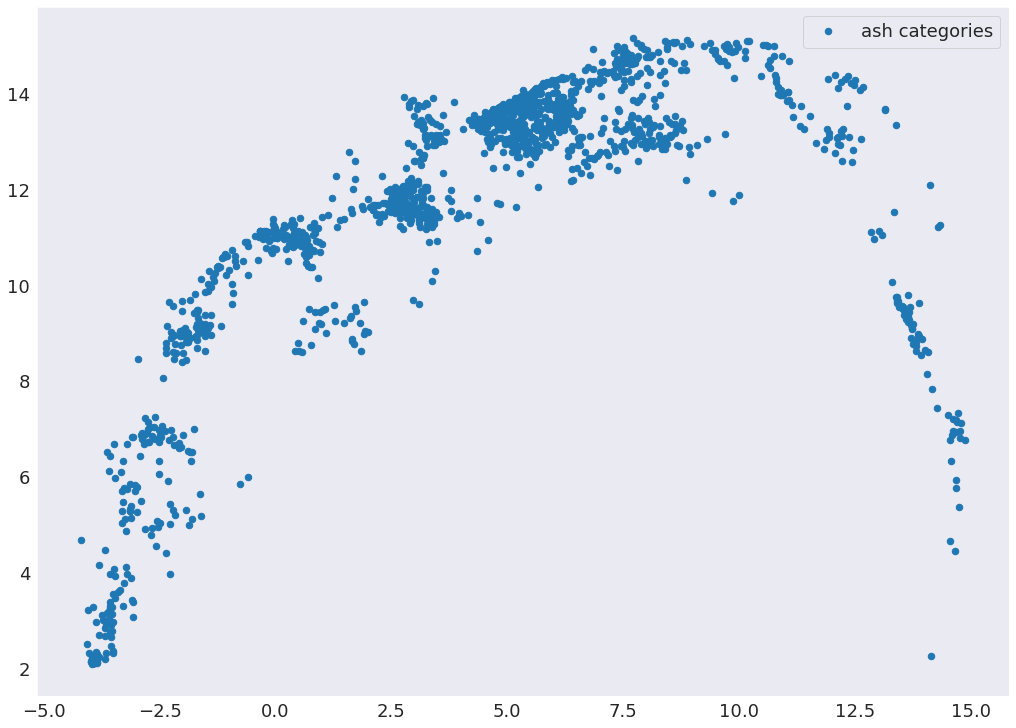

In [41]:
plt.figure(figsize=(14,10))
plt.plot(f_0_at[:,0],f_0_at[:,1],'.', label = "ash categories")
plt.grid(False)
plt.savefig('test_umap_samespace_ash.png')
plt.legend()

plt.show()

In [42]:

# ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

camp_p = predictions_ash_t[predictions_ash_t==0]

cor_p = predictions_pollen_tp[predictions_pollen_tp==1]



grim_p = predictions_ash_t[predictions_ash_t==3]

qro_p = predictions_pollen_tp[predictions_pollen_tp==4]

qsu_p = predictions_pollen_tp[predictions_pollen_tp==5]

dust_ttt = predictions_t[predictions_t==2]


tot_predictions_test = np.hstack((predictions_ash_t, predictions_pollen_tp, dust_ttt))

tot_predictions_test = np.array(tot_predictions_test)

print(tot_predictions_test)

#tot_predictions_test = pd.DataFrame(tot_predictions_test)

#tot_predictions_test = tot_predictions_test.sort_values(1)
#tot_predictions = tot_predictions_test[0].to_numpy()
print(np.argmax(tot_predictions_test, axis=0))



[3 0 3 ... 2 2 2]
1907


plt.figure(figsize=(14,10))
plt.hist([len(camp_p),len(cor_p),len(dust_p),len(grim_p),len(qro_p),len(qsu_p)], bins=6)

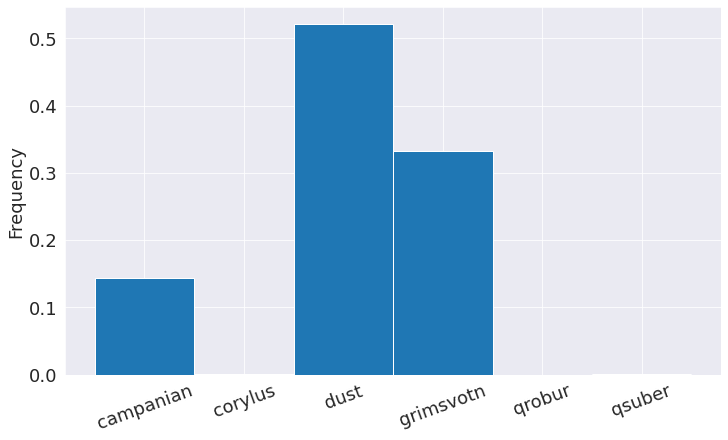

In [43]:
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.hist(tot_predictions_test, 6, range=(-0.5, 5.5), density=True);
ax1.set( ylabel='Frequency')
plt.xticks(range(6), ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"], rotation=20, fontsize=18)
plt.savefig('sub_categories_test_prediction_split.png')

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

<ipython-input-45-9042805d4e71>:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


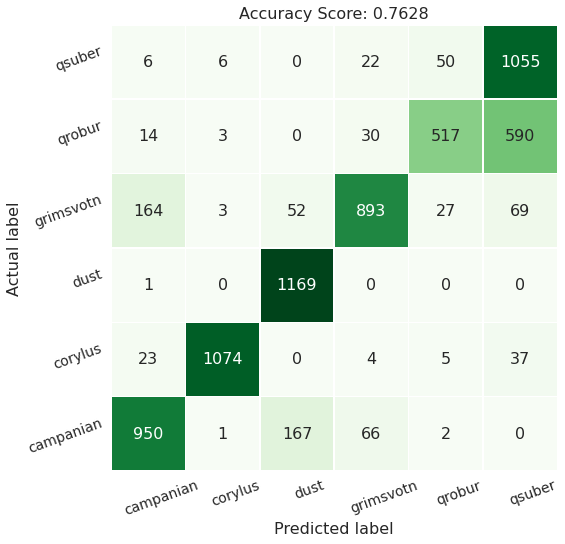

Correct: 5658/7000
Wrong: 1342/7000


In [45]:
fig=plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)

path = ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

plt.xticks(range(len(path)),path, rotation=20)
plt.yticks(range(len(path)),path, rotation=20)
plt.setp( ax.xaxis.get_majorticklabels()) 

import matplotlib.transforms

# Create offset transform by 5 points in x direction
dx = 50/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.setp( ax.yaxis.get_majorticklabels()) 

# Create offset transform by 5 points in x direction
dx = 0/72.; dy = 50/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
plt.tight_layout()
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))
fig.savefig('subtypes_conf_matrix', dpi=75)